Primera prueba:

vamos a aislar en un core a tensorflow, y vamos a medir con perf los eventos de dicho core.

vamos a hacer una ejecución corta de mnist.py, una sola época (puedes usar el código que ya tienes, mira a ver cómo se define el número de epochs), un solo thread (bajar intra e inter op parallelism a 1) y medir con perf.

Las stats que yo sacaría son: instrucciones totales, ciclos totales, instrucciones de punto flotante (ojo con estas, te va a tocar buscar cuales son de todas las disponibles en los eventos!!).

Comando: perf -e XXXX -C <n> taskset -c <n>x mnist_1epoch_1thread.py

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.4.1'

In [8]:
keras.__version__

'2.4.0'

Obtengo el numero de threads por defecto:

In [9]:
tf.config.threading.get_inter_op_parallelism_threads()

0

In [10]:
tf.config.threading.get_intra_op_parallelism_threads()

0

Configuro el intra y el inter a 1:

In [11]:
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [12]:
tf.config.threading.get_inter_op_parallelism_threads()

1

In [13]:
tf.config.threading.get_intra_op_parallelism_threads()

1

Empieza la ejecucion de MNIST

In [41]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [45]:
X_train_full.shape

(60000, 28, 28)

In [49]:
X_train_full.dtype

dtype('uint8')

In [53]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

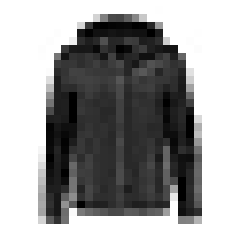

In [57]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [61]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [65]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [69]:
class_names[y_train[0]]

'Coat'

In [73]:
X_valid.shape

(5000, 28, 28)

In [77]:
X_test.shape

(10000, 28, 28)

Saving figure fashion_mnist_plot


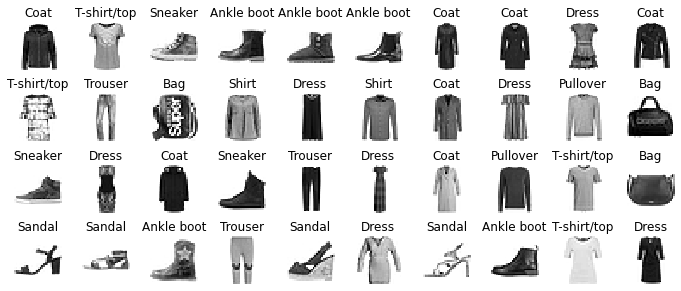

In [81]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [85]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.layers

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [78]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [82]:
hidden1 = model.layers[1]
hidden1.name

'dense_6'

In [86]:
model.get_layer(hidden1.name) is hidden1

ValueError: No such layer: dense_6.

In [90]:
weights, biases = hidden1.get_weights()

In [91]:
weights

array([[ 0.03003924, -0.03635277,  0.04822832, ..., -0.04054824,
        -0.07162483, -0.00197071],
       [ 0.00269923, -0.02012166,  0.01283706, ..., -0.03770145,
         0.02714255,  0.05917123],
       [-0.03650289,  0.07102856,  0.01462734, ...,  0.02953147,
        -0.06951421, -0.05037007],
       ...,
       [ 0.0288318 , -0.00157796, -0.01406798, ..., -0.03556325,
        -0.03672818,  0.06226417],
       [ 0.01157537,  0.06510615,  0.00158831, ...,  0.01476467,
        -0.05940248,  0.01595061],
       [ 0.0403823 ,  0.00496706, -0.05296481, ..., -0.03715949,
        -0.05509769, -0.04064666]], dtype=float32)

In [92]:
weights.shape

(784, 300)

In [93]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [94]:
biases.shape

(300,)

In [95]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Para ver los dispositivos que puedo usar:

In [96]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [97]:
tf.config.list_logical_devices(
    device_type=None
)

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [98]:
tf.config.get_visible_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [99]:
tf.config.experimental.get_device_policy()

'silent'

In [100]:
physical_devices = tf.config.list_physical_devices('CPU')
assert len(physical_devices) == 1, "No CPUs found"
configs = tf.config.get_logical_device_configuration(
  physical_devices[0])
try:
  assert configs is None
  tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(),
     tf.config.LogicalDeviceConfiguration()])
  configs = tf.config.get_logical_device_configuration(
    physical_devices[0])
  assert len(configs) == 2
except:
  # Cannot modify virtual devices once initialized.
  pass

In [101]:
tf.config.get_visible_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [102]:
tf.config.experimental.get_device_policy()

'silent'

In [103]:
tf.device(
    '/device:XLA_CPU:0'
)

In [104]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 5s 3ms/step - loss: 0.9878 - accuracy: 0.6878 - val_loss: 0.5208 - val_accuracy: 0.8246


In [105]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 1719}

In [106]:
print(history.epoch)

[0]


In [107]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])